# Modeling of National US Education



In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import math

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import validation_curve
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve

In [2]:
x_train = pd.read_csv("C:/Users/book_/OneDrive/Desktop/Data_Storage/US_Education/clean_data/x_train.csv", index_col=0)
y_train = pd.read_csv("C:/Users/book_/OneDrive/Desktop/Data_Storage/US_Education/clean_data/y_train.csv", index_col=0)

x_test = pd.read_csv("C:/Users/book_/OneDrive/Desktop/Data_Storage/US_Education/clean_data/x_test.csv", index_col=0)
y_test = pd.read_csv("C:/Users/book_/OneDrive/Desktop/Data_Storage/US_Education/clean_data/y_test.csv", index_col=0)

In [3]:
print(x_train.shape)
print(y_train.shape)
y_train_1d = y_train.values.flatten()
y_train_1d.shape

(12, 10)
(12, 1)


(12,)

# I. Linear Regression

In [4]:
pipe = make_pipeline(
    StandardScaler(),
    SelectKBest(f_regression),
    LinearRegression()
)

In [5]:
pipe.fit(x_train, y_train_1d)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('selectkbest',
                 SelectKBest(score_func=<function f_regression at 0x0000024316152160>)),
                ('linearregression', LinearRegression())])

In [6]:
y_tr_pred = pipe.predict(x_train)
y_te_pred = pipe.predict(x_test)

In [7]:
r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)

(0.9832351548002036, -151.82556685189755)

In [8]:
mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)

(0.2509510933467993, 4.092567442237282)

In [9]:
k = [k+1 for k in range(len(x_train.columns))]
grid_params = {'selectkbest__k': k}

lr_grid_cv = GridSearchCV(pipe, param_grid=grid_params, cv=5, n_jobs=-1)

lr_grid_cv.fit(x_train, y_train)

score_mean = lr_grid_cv.cv_results_['mean_test_score']
score_std = lr_grid_cv.cv_results_['std_test_score']
cv_k = [k for k in lr_grid_cv.cv_results_['param_selectkbest__k']]

lr_grid_cv.best_params_

C:\Users\book_\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


{'selectkbest__k': 5}

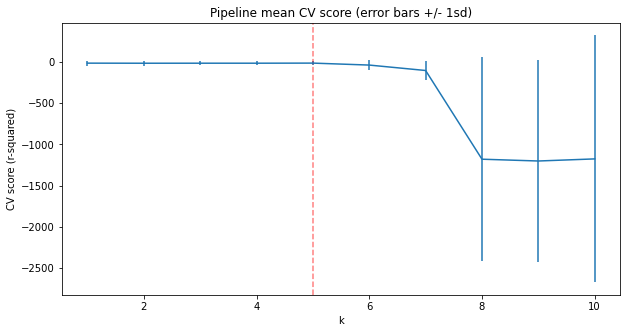

In [10]:
best_k = lr_grid_cv.best_params_['selectkbest__k']
plt.subplots(figsize=(10, 5))
plt.errorbar(cv_k, score_mean, yerr=score_std)
plt.axvline(x=best_k, c='r', ls='--', alpha=.5)
plt.xlabel('k')
plt.ylabel('CV score (r-squared)')
plt.title('Pipeline mean CV score (error bars +/- 1sd)');

In [11]:
#This doesn't run correctly

selected = lr_grid_cv.best_estimator_.named_steps.selectkbest.get_support()
coefs = lr_grid_cv.best_estimator_.named_steps.linearregression.coef_
features = x_train.columns[selected]
#pd.Series(coefs, index=features).sort_values(ascending=False)

In [12]:
print(selected)
print(x_train.columns)
print(coefs)
print(features)

[False  True False False  True False  True  True  True False]
Index(['ENROLL', 'TOTAL_REVENUE', 'FEDERAL_REVENUE', 'STATE_REVENUE',
       'LOCAL_REVENUE', 'TOTAL_EXPENDITURE', 'INSTRUCTION_EXPENDITURE',
       'SUPPORT_SERVICES_EXPENDITURE', 'OTHER_EXPENDITURE',
       'CAPITAL_OUTLAY_EXPENDITURE'],
      dtype='object')
[[ 1.97440192 -0.33446473  4.88019353 -4.48278908  0.45761949]]
Index(['TOTAL_REVENUE', 'LOCAL_REVENUE', 'INSTRUCTION_EXPENDITURE',
       'SUPPORT_SERVICES_EXPENDITURE', 'OTHER_EXPENDITURE'],
      dtype='object')


The out put for the "Series" Line of code should have come out as:

INSTRUCTION_EXPENDITURE: 4.88019353

TOTAL_REVENUE: 1.97440192

OTHER_EXPENDITURE: 0.45761949

LOCAL_REVENUE: -0.33446473

SUPPORT_SERVICES_EXPENDITURE: -4.48278908

This is interesting as it shows a strong positive corrilation with Instructional expenditures, which is to be expected. However the strong negative corrialtion with Support Services is not. Support services in schools are things such as:

School Nurse
Guidance Counselor
English Learners
Behavior Specialist
Instructional Specialist
Speech Specialist
Remedial Services
ect.

The implication here is that these hurt the overall scores. So what we are going to do is look at this same model but by state instead of using just the national data.

In [13]:
x_train_s = pd.read_csv("C:/Users/book_/OneDrive/Desktop/Data_Storage/US_Education/clean_data/x_train_states.csv", index_col=0)
y_train_s = pd.read_csv("C:/Users/book_/OneDrive/Desktop/Data_Storage/US_Education/clean_data/y_train_states.csv", index_col=0)

x_test_s = pd.read_csv("C:/Users/book_/OneDrive/Desktop/Data_Storage/US_Education/clean_data/x_test_states.csv", index_col=0)
y_test_s = pd.read_csv("C:/Users/book_/OneDrive/Desktop/Data_Storage/US_Education/clean_data/y_test_states.csv", index_col=0)

In [14]:
y_train_s1d = y_train_s.values.flatten()
y_train_s1d.shape

(612,)

In [15]:
pipe_s = make_pipeline(
    StandardScaler(),
    SelectKBest(f_regression),
    LinearRegression()
)

pipe_s.fit(x_train_s, y_train_s1d)

k_s = [k+1 for k in range(len(x_train_s.columns))]
grid_params_s = {'selectkbest__k': k_s}

lr_grid_cv_s = GridSearchCV(pipe_s, param_grid=grid_params_s, cv=5, n_jobs=-1)

lr_grid_cv_s.fit(x_train_s, y_train_s1d)

score_mean_s = lr_grid_cv_s.cv_results_['mean_test_score']
score_std_s = lr_grid_cv_s.cv_results_['std_test_score']
cv_k_s = [k for k_s in lr_grid_cv_s.cv_results_['param_selectkbest__k']]

lr_grid_cv_s.best_params_

{'selectkbest__k': 2}

In [16]:
best_k_s = lr_grid_cv_s.best_params_['selectkbest__k']
#plt.subplots(figsize=(10, 5))
#plt.errorbar(cv_k_s, score_mean_s, yerr=score_std_s)
#plt.axvline(x=best_k_s, c='r', ls='--', alpha=.5)
#plt.xlabel('k')
#plt.ylabel('CV score (r-squared)')
#plt.title('Pipeline mean CV score (error bars +/- 1sd)');

In [17]:
selected = lr_grid_cv_s.best_estimator_.named_steps.selectkbest.get_support()
coefs = lr_grid_cv_s.best_estimator_.named_steps.linearregression.coef_
features = x_train_s.columns[selected]
pd.Series(coefs, index=features).sort_values(ascending=False)

LOCAL_REVENUE      4.543618
FEDERAL_REVENUE   -4.427660
dtype: float64

This turned out less informative than the national data.

# II. Random Forest Model

In [18]:
RF_pipe = make_pipeline(
    StandardScaler(),
    RandomForestRegressor()
)

rf_default_cv_results = cross_validate(RF_pipe, x_train, y_train_1d, cv=5)

In [19]:
rf_cv_scores = rf_default_cv_results['test_score']
rf_cv_scores

array([-6.92642779e+01, -1.35254583e+00, -3.17936879e+00, -2.13684717e+01,
        2.17490359e-02])

In [20]:
np.mean(rf_cv_scores), np.std(rf_cv_scores)

(-19.028583042523806, 26.289371074807594)

In [21]:
n_est = [int(n) for n in np.logspace(start=1, stop=3, num=20)]
grid_params = {
        'randomforestregressor__n_estimators': n_est,
        'standardscaler': [StandardScaler(), None]
}
grid_params

{'randomforestregressor__n_estimators': [10,
  12,
  16,
  20,
  26,
  33,
  42,
  54,
  69,
  88,
  112,
  143,
  183,
  233,
  297,
  379,
  483,
  615,
  784,
  1000],
 'standardscaler': [StandardScaler(), None]}

In [22]:
rf_grid_cv = GridSearchCV(RF_pipe, param_grid=grid_params, cv=5, n_jobs=-1)
rf_grid_cv.fit(x_train, y_train)

C:\Users\book_\anaconda3\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('randomforestregressor',
                                        RandomForestRegressor())]),
             n_jobs=-1,
             param_grid={'randomforestregressor__n_estimators': [10, 12, 16, 20,
                                                                 26, 33, 42, 54,
                                                                 69, 88, 112,
                                                                 143, 183, 233,
                                                                 297, 379, 483,
                                                                 615, 784,
                                                                 1000],
                         'standardscaler': [StandardScaler(), None]})

In [23]:
rf_grid_cv.best_params_

{'randomforestregressor__n_estimators': 16, 'standardscaler': None}

In [24]:
rf_best_cv_results = cross_validate(rf_grid_cv.best_estimator_, x_train, y_train_1d, cv=5)
rf_best_scores = rf_best_cv_results['test_score']
rf_best_scores

array([-67.98262117,  -1.08022797,  -3.92740961, -18.2918625 ,
         0.57769317])

In [25]:
np.mean(rf_best_scores), np.std(rf_best_scores)

(-18.140885616893552, 25.798044610432708)

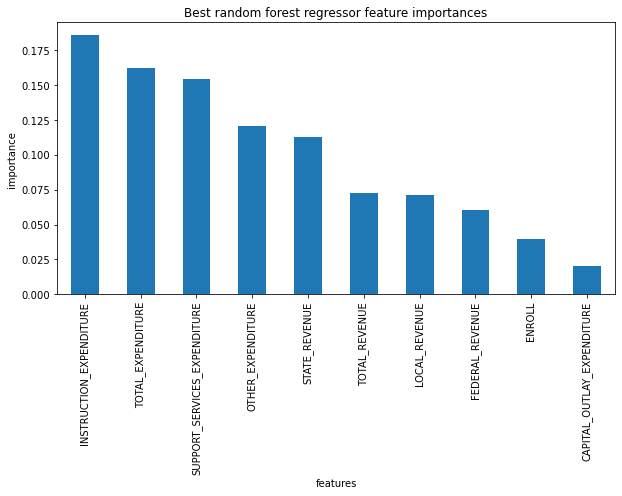

In [26]:
plt.subplots(figsize=(10, 5))
imps = rf_grid_cv.best_estimator_.named_steps.randomforestregressor.feature_importances_
rf_feat_imps = pd.Series(imps, index=x_train.columns).sort_values(ascending=False)
rf_feat_imps.plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best random forest regressor feature importances');

# Model Comparison

In [27]:
lr_neg_mae = cross_validate(lr_grid_cv.best_estimator_, x_train, y_train, 
                            scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)
lr_mae_mean = np.mean(-1 * lr_neg_mae['test_score'])
lr_mae_std = np.std(-1 * lr_neg_mae['test_score'])
lr_mae_mean, lr_mae_std

(0.7939897235677071, 0.39289840624031586)

In [28]:
mean_absolute_error(y_test, lr_grid_cv.best_estimator_.predict(x_test))

5.000485644366677

In [29]:
rf_neg_mae = cross_validate(rf_grid_cv.best_estimator_, x_train, y_train, 
                            scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

rf_mae_mean = np.mean(-1 * rf_neg_mae['test_score'])
rf_mae_std = np.std(-1 * rf_neg_mae['test_score'])
rf_mae_mean, rf_mae_std

(1.0784313725490373, 0.9188689818850185)

In [30]:
mean_absolute_error(y_test, rf_grid_cv.best_estimator_.predict(x_test))

0.817708333333357

We have a significantly lower error on the Random Forest model, making it the better of the two models

# Analysis

For the sake of this project, we are going to use Florida as our state of interest. The question we will now ask is:

## In order to increase the test scores of 8th grade students, should Florida increase their expenditure?

First lets refit our model to all the data except Florida.

In [31]:
us_ed = pd.read_csv(r"C:\Users\book_\OneDrive\Desktop\Data_Storage\US_Education\clean_data\state_ed_03_19_reduced.csv", index_col=0)
us_ed


,STATE,YEAR,STATE_ABBREVIATION,ENROLL,TOTAL_REVENUE,FEDERAL_REVENUE,STATE_REVENUE,LOCAL_REVENUE,TOTAL_EXPENDITURE,INSTRUCTION_EXPENDITURE,...,G08_HI_A_READING,G08_HI_A_MATHEMATICS,G08_AS_A_READING,G08_AS_A_MATHEMATICS,G08_AM_A_READING,G08_AM_A_MATHEMATICS,G08_HP_A_READING,G08_HP_A_MATHEMATICS,G08_TR_A_READING,G08_TR_A_MATHEMATICS
0,ALABAMA,2003,AL,727900.0,5196054.0,567704.0,2966981.0,1661369.0,5298932.0,2817111.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ALABAMA,2004,AL,730418.0,5356113.0,625666.0,2971520.0,1758927.0,5450269.0,2875595.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ALABAMA,2005,AL,729342.0,5889966.0,665924.0,3247562.0,1976480.0,5904664.0,3053380.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ALABAMA,2006,AL,743265.0,6364028.0,730112.0,3540436.0,2093480.0,6591429.0,3326656.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ALABAMA,2007,AL,743273.0,7069040.0,689072.0,4070949.0,2309019.0,7196459.0,3653466.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
811,WYOMING,2014,WY,92732.0,1772633.0,112709.0,965213.0,694711.0,1775999.0,865932.0,...,259.5,275.5,NaN,NaN,248.75,260.0,NaN,NaN,NaN,NaN
812,WYOMING,2015,WY,93867.0,1962874.0,120290.0,1116917.0,725667.0,1942406.0,895910.0,...,258.0,273.0,NaN,NaN,249.50,251.0,NaN,NaN,NaN,NaN
813,WYOMING,2016,WY,94511.0,2044669.0,123012.0,1175899.0,745758.0,2034229.0,921494.0,...,259.5,274.0,NaN,NaN,250.25,259.5,NaN,NaN,NaN,NaN
814,WYOMING,2017,WY,94511.0,2044669.0,123012.0,1175899.0,745758.0,2034229.0,921494.0,...,261.0,275.0,NaN,NaN,251.00,268.0,NaN,NaN,NaN,NaN


In [32]:
x = us_ed.loc[us_ed.STATE != 'FLORIDA', x_train.columns]
y = us_ed.loc[us_ed.STATE != 'FLORIDA', 'G08_A_A_MATHEMATICS']
rf_grid_cv.fit(x, y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('randomforestregressor',
                                        RandomForestRegressor())]),
             n_jobs=-1,
             param_grid={'randomforestregressor__n_estimators': [10, 12, 16, 20,
                                                                 26, 33, 42, 54,
                                                                 69, 88, 112,
                                                                 143, 183, 233,
                                                                 297, 379, 483,
                                                                 615, 784,
                                                                 1000],
                         'standardscaler': [StandardScaler(), None]})

In [33]:
cv_results = cross_validate(rf_grid_cv, x, y, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)
cv_results['test_score']

array([-9.43618304, -5.68517005, -7.2314793 , -5.2872846 , -4.87105956])

In [34]:
mae_mean, mae_std = np.mean(-1 * cv_results['test_score']), np.std(-1 * cv_results['test_score'])
mae_mean, mae_std

(6.502235308199985, 1.6699869020311446)

Calculating the expected 8th grade scores for Florida in 2018

In [35]:
x_FL = us_ed.loc[us_ed.STATE == 'FLORIDA', x_train.columns]
y_FL = us_ed.loc[us_ed.STATE == 'FLORIDA', 'G08_A_A_MATHEMATICS']
FL_pred = rf_grid_cv.predict(x_FL)
#y_FL = y_FL.values.item()
print(f'Florida modelled score is:')
print(FL_pred[-1])
print('the actual score is:')
print(y_FL.tail(1))

Florida modelled score is:
279.7291666666667
the actual score is:
159    279.0
Name: G08_A_A_MATHEMATICS, dtype: float64


This is good that our model is performing well at predicting the performance in Florida.

Now our random forest model identified the most important features to be:

- Instruction Expenditure
- Support Service Expenditure
- Local Revenue
- Total Expenditure
- Enroll
- Total Revenue
- State Revenue
- Federal Revenue
- Capital Outlay Expenditure
- Other Expenditure

Let's focus on the top 5.

In [36]:
def predict_increase(features, deltas):
    """Increase in modelled score by applying delta to feature.
    
    Arguments:
    features - list, names of the features in the us_education dataframe to change
    deltas - list, the amounts by which to increase the values of the features
    
    Outputs:
    Amount of increase in the predicted score
    """
    
    fl2 = x_FL.copy()
    for f, d in zip(features, deltas):
        fl2[features] += deltas
    new = rf_grid_cv.predict(fl2)
    return new[-1] - FL_pred[-1]

# 1. Increasing Instructional Expenditure

In [63]:
instruction_delta = [-5000000, 0, 5000000, 10000000, 15000000, 20000000, 25000000, 30000000]
score_deltas = [predict_increase(['INSTRUCTION_EXPENDITURE'], [delta]) for delta in instruction_delta]

In [64]:
score_deltas

[0.0,
 0.0,
 0.16666666666662877,
 0.16666666666662877,
 0.3333333333333144,
 0.3333333333333144,
 0.3333333333333144,
 0.3333333333333144]

[Text(0.5, 0, 'Change in Instructional Expenditure'),
 Text(0, 0.5, 'Change in Score'),
 Text(0.5, 1.0, 'Instrucitonal Expenditure')]

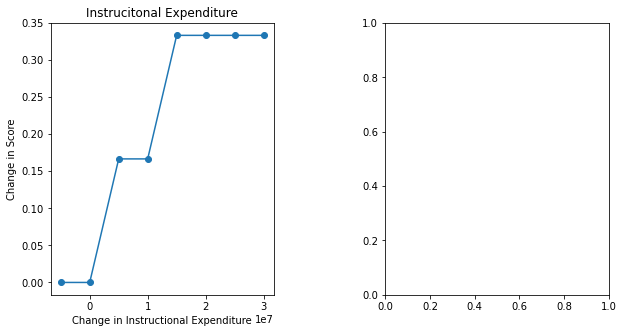

In [65]:
fig, ax = plt.subplots(1,2, figsize=(10, 5))
fig.subplots_adjust(wspace=0.5)
ax[0].plot(instruction_delta, score_deltas, 'o-')
ax[0].set(xlabel='Change in Instructional Expenditure', ylabel='Change in Score', title='Instrucitonal Expenditure')

The model says increasing the Instructional Expenditure will benefit our scores

In [66]:
instruction_delta_2 = [(i+1)*2000000 for i in range(15)]
instruction_delta_2

[2000000,
 4000000,
 6000000,
 8000000,
 10000000,
 12000000,
 14000000,
 16000000,
 18000000,
 20000000,
 22000000,
 24000000,
 26000000,
 28000000,
 30000000]

In [67]:
score_deltas_2 = [predict_increase(['INSTRUCTION_EXPENDITURE'], [delta]) for delta in instruction_delta_2]

In [68]:
score_deltas_2

[0.0,
 0.16666666666662877,
 0.16666666666662877,
 0.16666666666662877,
 0.16666666666662877,
 0.3333333333333144,
 0.3333333333333144,
 0.3333333333333144,
 0.3333333333333144,
 0.3333333333333144,
 0.3333333333333144,
 0.3333333333333144,
 0.3333333333333144,
 0.3333333333333144,
 0.3333333333333144]

[Text(0.5, 0, 'Change in millions'),
 Text(0, 0.5, 'Change in Score'),
 Text(0.5, 1.0, 'Instrucitonal Expenditure')]

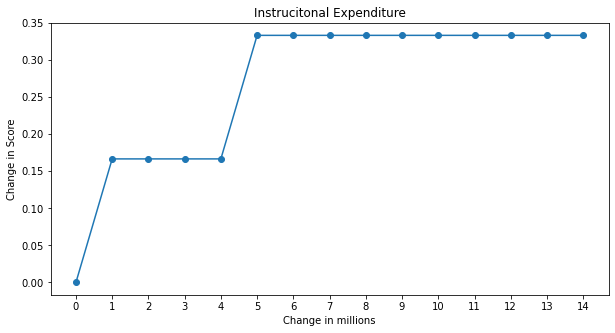

In [69]:
fig, ax = plt.subplots( figsize=(10, 5))
fig.subplots_adjust(wspace=0.5)
ax.plot(instruction_delta_2, score_deltas_2, 'o-')
ax.set_xticks(instruction_delta_2)
ax.set_xticklabels([i for i in range(len(instruction_delta_2))])
ax.set(xlabel='Change in millions', ylabel='Change in Score', title='Instrucitonal Expenditure')

It looks like here that we can a either increase by 1 million and get a .17 point increase or increase by 5 million and get a .33 point increase.

# 2. Support Service Expenditure

In [44]:
support_delta = [-5000000, 0, 5000000, 10000000, 15000000, 20000000]
score_deltas = [predict_increase(['SUPPORT_SERVICES_EXPENDITURE'], [delta]) for delta in support_delta]
score_deltas

[0.25,
 0.0,
 0.41666666666662877,
 -1.4583333333333712,
 -1.3333333333333712,
 -1.3333333333333712]

[Text(0.5, 0, 'Change in millions'),
 Text(0, 0.5, 'Change in Score'),
 Text(0.5, 1.0, 'Support Services Expenditure')]

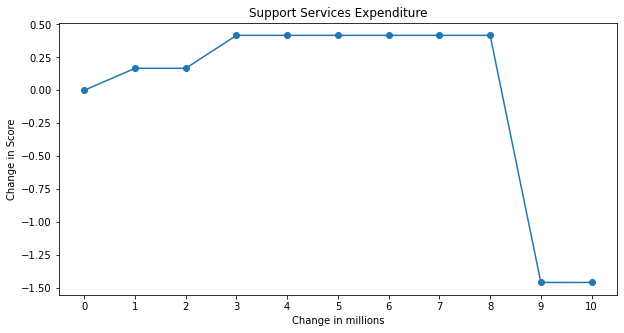

In [70]:
support_delta_2 = [i*1000000 for i in range(11)]
score_deltas_2 = [predict_increase(['SUPPORT_SERVICES_EXPENDITURE'], [delta]) for delta in support_delta_2]

fig, ax = plt.subplots( figsize=(10, 5))
fig.subplots_adjust(wspace=0.5)
ax.plot(support_delta_2, score_deltas_2, 'o-')
ax.set_xticks([i*1000000 for i in range(11)])
ax.set_xticklabels([i for i in range(11)])
ax.set(xlabel='Change in millions', ylabel='Change in Score', title='Support Services Expenditure')

We can increase our scores by almost .5 points by increasing support expenditures to 3 million

# 3. Local Revenue

In [46]:
local_delta = [-10000000, -5000000, 0, 5000000, 10000000, 15000000, 20000000, 25000000, 30000000]
score_deltas = [predict_increase(['LOCAL_REVENUE'], [delta]) for delta in local_delta]
score_deltas

[0.0,
 0.0,
 0.0,
 0.0,
 0.04166666666662877,
 0.04166666666662877,
 0.04166666666662877,
 0.04166666666662877,
 0.04166666666662877]

[Text(0.5, 0, 'Change in millions'),
 Text(0, 0.5, 'Change in Score'),
 Text(0.5, 1.0, 'Local Revenue')]

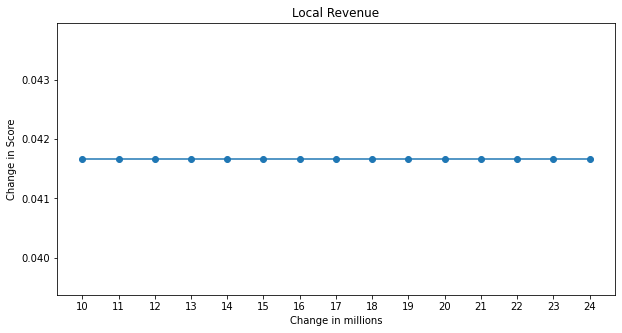

In [47]:
local_delta_2 = [(i+10)*1000000 for i in range(15)]
score_deltas_2 = [predict_increase(['LOCAL_REVENUE'], [delta]) for delta in local_delta_2]

fig, ax = plt.subplots( figsize=(10, 5))
fig.subplots_adjust(wspace=0.5)
ax.plot(local_delta_2, score_deltas_2, 'o-')
ax.set_xticks(local_delta_2)
ax.set_xticklabels([i+10 for i in range(15)])
ax.set(xlabel='Change in millions', ylabel='Change in Score', title='Local Revenue')

This one may be a bit more difficult to do, but if we can increase the Local revenue, it appears we can increase the scores. The current maximum we're looking at is about a .13 point increase if we can get an increase of 11 million in Local Revenue.

# 4. Total Expenditure

In [48]:
total_delta = [-10000000, -5000000, 0, 5000000, 10000000, 15000000, 20000000, 25000000, 30000000, 40000000, 50000000, 60000000, 70000000]
score_deltas = [predict_increase(['TOTAL_EXPENDITURE'], [delta]) for delta in total_delta]
score_deltas

[0.0,
 -0.16666666666668561,
 0.0,
 0.0,
 -0.16666666666668561,
 -0.16666666666668561,
 -0.16666666666668561,
 -0.16666666666668561,
 -0.16666666666668561,
 -0.16666666666668561,
 -0.16666666666668561,
 -0.16666666666668561,
 -0.16666666666668561]

[Text(0.5, 0, 'Change in millions'),
 Text(0, 0.5, 'Change in Score'),
 Text(0.5, 1.0, 'Total Expenditure')]

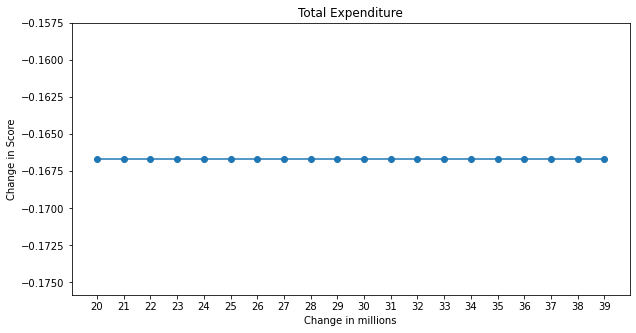

In [49]:
# between 20 and 40 million
total_delta_2 = [(i+20)*1000000 for i in range(20)]
score_deltas_2 = [predict_increase(['TOTAL_EXPENDITURE'], [delta]) for delta in total_delta_2]

fig, ax = plt.subplots( figsize=(10, 5))
fig.subplots_adjust(wspace=0.5)
ax.plot(total_delta_2, score_deltas_2, 'o-')
ax.set_xticks(total_delta_2)
ax.set_xticklabels([i+20 for i in range(20)])
ax.set(xlabel='Change in millions', ylabel='Change in Score', title='Total Expenditure')

In this version:
We see a decrease in score by changing the total expenditure


In a previous model version:

We saw a small increase in score by increasing the expendutre by 10-15 million, but starting at about 20 million we see at minimum a .3 point increase in the score. If it is possible to increase the total expenditure by 32 million we could possibly get a .34 point increase.

# 5. Enrollment

[Text(0.5, 0, 'Change in millions'),
 Text(0, 0.5, 'Change in Score'),
 Text(0.5, 1.0, 'Enrollment')]

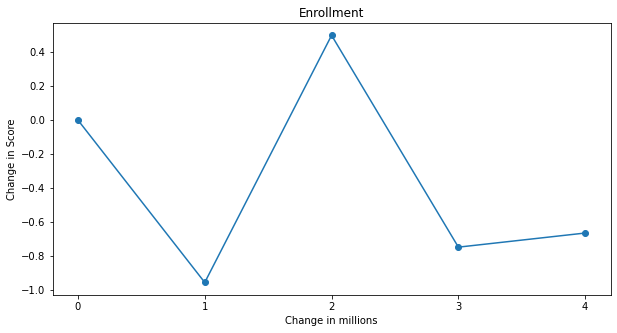

In [50]:
enroll_delta = [i*1000000 for i in range(5)]
score_deltas = [predict_increase(['ENROLL'], [delta]) for delta in enroll_delta]

fig, ax = plt.subplots( figsize=(10, 5))
fig.subplots_adjust(wspace=0.5)
ax.plot(enroll_delta, score_deltas, 'o-')
ax.set_xticks(enroll_delta)
ax.set_xticklabels([i for i in range(5)])
ax.set(xlabel='Change in millions', ylabel='Change in Score', title='Enrollment')

There doesn't appear to be much increase in score by enrollment, which is also something we don't necessarily have control over, but we can see a .005 increase in enrollment if we increase enrollment by 2 million.

# Combination

Let's look at the score increase with a combination of these senarios.

1) Increase Instructional Expenditure by 5 million dollars

2) Increase Support Services Exepnditure by 3 million dollars

3) Incresae Local Revenue by 10 million

4) No change Total Expenditure

5) Increase Enrollment by 1 million

In [83]:
score_increase = predict_increase(['INSTRUCTION_EXPENDITURE','SUPPORT_SERVICES_EXPENDITURE', 'LOCAL_REVENUE', 'ENROLL'], [5000000, 3000000, 1000000, 1000000])
score_increase

-1.3402777777777715

In [84]:
# Instructional and Support increase
score_increase = predict_increase(['INSTRUCTION_EXPENDITURE', 'SUPPORT_SERVICES_EXPENDITURE'], [5000000, 3000000])
score_increase

0.5833333333333144

In [81]:
#instruction, Support, and Revenue
score_increase = predict_increase(['INSTRUCTION_EXPENDITURE', 'SUPPORT_SERVICES_EXPENDITURE', 'LOCAL_REVENUE'], [5000000, 3000000, 1000000])
score_increase

-1.2916666666666856

In [79]:
# Instruction, Support, Enroll
score_increase = predict_increase(['INSTRUCTION_EXPENDITURE', 'SUPPORT_SERVICES_EXPENDITURE', 'ENROLL'], [5000000, 3000000, 1000000])
score_increase

-1.7361111111110858

In [80]:
#Instruction and Revenue
score_increase = predict_increase(['INSTRUCTION_EXPENDITURE', 'LOCAL_REVENUE'], [5000000, 1000000])
score_increase

0.16666666666662877

In [82]:
score_increase = predict_increase(['INSTRUCTION_EXPENDITURE', 'TOTAL_EXPENDITURE'], [5000000, 1000000])
score_increase

0.16666666666662877

We could do more of these senarios to test what could be best for Florida, it looks like doing all of the things that individually increase the score, doesn't necessiarily corrilate to an increase in score when all done together.

However of the ones we performed in this notebook the combination of increasing instruction and support expenditures has provided the best score increase.

# Summary

We saw incrimental score increases in each of our individual important features. In future work we could look at the other top features and see how they interact with each other and test other possible senarios. Also remember that we made certain decisions for this project such as choosing Florida and to analyse 8th grade math scores. We also have reading scores and scores based on demographics that we could run a copy of this notebook with the state and demographic of interest changed. As we have chosen our interests, the most important features were:

- Instruction Expenditure
- Support Service Expenditure
- Local Revenue
- Total Expenditure
- Enroll
- Total Revenue
- State Revenue
- Federal Revenue
- Capital Outlay Expenditure
- Other Expenditure

The ranking of these has changed with different models but Instruction and Support tend to be in the top most of the time.
With this reason we will choose our proposed action to helping Florida increase their 8th grade mathematics scores by increasing their Instruction Expenditure by 5 million dollars and their Support Service Expenditure by 3 million dollars. This can acheive us a .58 score increase (according to the current model version). This may seem like a small increment, but change overtime can benefit students greatly.

We hope in the future we can look further into the demographics to see how best we can help our students to grow in their learning.

Note: In the future we should do a version control so that there is consistancy with each time the notebook is ran. Right now if you run the notebook you may not necissarily have the same numbers as what I have achieved in my notes. 